Tutorial 2

*   Klasifikasi
*   Regresi


kindly **change runtime type to use GPU** for running TensorFlow later!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot

import time

from sklearn import model_selection #Library untuk proses prediksi
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold, ShuffleSplit, StratifiedShuffleSplit # Library untuk splitting data train:test
# Library untuk menampilkan nilai pengujian Cross Validation
from sklearn.model_selection import cross_val_score, cross_validate
# Library untuk balancing data
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
# Library untuk feature scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split # Library untuk memisahkan data menjadi data training:testing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # library untuk menerapkan gridsearch dan randomsearch
from sklearn.metrics import roc_auc_score , roc_curve , make_scorer , accuracy_score , precision_score , recall_score , f1_score, confusion_matrix, classification_report # Menampilkan hasil tes
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix #plotting confusion matrix

from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # Library untuk metode Random Forest
from sklearn.neighbors import KNeighborsClassifier # Library untuk metode KNN
from sklearn.naive_bayes import GaussianNB # Klasifikasi Naive Bayes
from sklearn.svm import SVC, SVR # Library untuk metode SVM
# from sklearn.neural_network import MLPClassifier # # Library untuk metode Neural Network di scikit-learn
from sklearn.linear_model import LogisticRegression, LinearRegression # Library untuk Logistic and Linear Regression

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model # visualize model

## Klasifikasi

### Preparing the Dataset

In [ ]:
# Dataset
titanic = sns.load_dataset('titanic')
titanic

In [ ]:
titanic.describe()

In [ ]:
# Cek nilai unik pada kolom yang kategorikal
categorical_columns = []
for cols in list(titanic.columns):
  if titanic[cols].dtype not in ['float','int']:
    categorical_columns.append(cols)

print('\nUnique values in Categorical columns\n')
for catg_cols in categorical_columns:
  print(f'{catg_cols}: {titanic[catg_cols].unique()}\n')

In [ ]:
titanic.info()

Note : Metode klasifikasi di python tidak bisa berjalan jika masih berupa object (string), sehingga data perlu diubah menjadi angka (integer/float) seperti yang dijelaskan pada tutorial 1. Selain itu, data kosong (nan) juga tidak bisa digunakan.


    Survival - Survival (0 = No; 1 = Yes).
    Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
    Name - Name
    Sex - Sex
    Age - Age
    Sibsp - Number of Siblings/Spouses Aboard
    Parch - Number of Parents/Children Aboard
    Fare - Passenger Fare
    Deck - Deck section
    Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [ ]:
titanic1 = titanic.copy()
titanic1

#### Missing values

Di tutorial 1, kita juga membahas gimana ngatasi *missing value*.  Ada beberapa opsi buat ngatasinya:

*   Dihapus?
*   Diisi angka lain? (metode **imputasi**)
  *   Nilai paling sering muncul (modus)
  *   Nilai pada baris sebelumnya
  *   Nilai rata-rata / Nilai median
  *   dll

In [ ]:
# Cek Nilai Null
titanic.isnull().sum()

> Missing values pada kolom "age"

Pada kolom "who", terdapat nilai **child** sehingga kita perlu hati-hati saat akan mengimputasikan nilai di kolom "age". Pastikan apakah data yang hilang ini berkaitan dengan anak-anak atau orang dewasa. Misal, jika terkait dengan data anak-anak, maka ganti NaN dengan usia yang paling banyak muncul pada kategori **child**

In [ ]:
titanic['who'].value_counts()

In [ ]:
titanic[titanic['age'].isnull()] #baris data dengan informasi "age" yang NaN

In [ ]:
titanic[titanic['age'].isnull()]['who'].value_counts() #baris data yang tidak ada informasi "age" nya tsb. ternyata dari kategori "man" & "woman"

In [ ]:
# kita cek berapakah umur yang paling sering muncul
age_modus = titanic1['age'].value_counts().idxmax()
print("Umur penumpang mayoritas berusia {}".format(age_modus))

In [ ]:
# imputasi kolom "age" dengan usia yang paling sering muncul
titanic1['age'].fillna(age_modus, inplace=True)
titanic1

In [ ]:
titanic1.isnull().sum()

> Missing values pada kolom "deck"

In [ ]:
# Hapus kolom "deck", karena banyak yg null
titanic1.drop(columns = 'deck', inplace=True)
titanic1

In [ ]:
titanic1.isna().sum()

> Missing values pada kolom "embark_town" dan "embarked"

Karena hanya ada 2 missing values pada kolom-kolom tersebut, maka kali ini, kita coba hapus baris tersebut

In [ ]:
# cek baris yang ada missing values di kolom "embark_town" atau "embarked"
titanic1[titanic1['embarked'].isna() | titanic1['embark_town'].isna()]

In [ ]:
# hapus 2 baris tsb.
titanic1.dropna(axis=0, inplace=True)

titanic1.isna().sum()

#### Categorical encoding

Menerapkan praktik categorical encoding seperti di Tutorial 1 kemarin

Alternatif untuk menerapkan categorical encoding:
1. Label Encoding (mengubah tiap kategori menjadi label 1,2,3, dst.)
    * tool: sklearn LabelEncoder(), pandas.factorize(), mapping nilai secara manual
2. One Hot Encoding (mengubah tiap kategori menjadi kolom baru dengan nilai 0/1 yang bermakna True/False)
    * tool: pandas.get_dummies(), sklearn OneHotEncoder 

> Mengubah nilai pada fitur 'sex' menjadi 1 untuk male dan 0 untuk female

In [ ]:
titanic1['sex'] = titanic1['sex'].map({'male': 1 , 'female': 0})
titanic1.head()

> Mengubah nilai pada fitur 'alone' menjadi 1 untuk True dan 0 untuk False

In [ ]:
titanic1['alone'] = titanic1['alone'].map({True: 1, False: 0})
titanic1.head()

> Mencoba menerapkan one-hot encoding terhadap kolom "embark_town"

In [ ]:
# cek kolom embarked & embark_town
titanic1[['embarked', 'embark_town']]

In [ ]:
# one hot encoding thdp kolom "embark_town"
titanic1 = titanic1.join(pd.get_dummies(titanic1['embark_town']))

# kemudian drop kolom embarked dan embark_town
titanic1 = titanic1.drop(columns = ['embarked', 'embark_town'])

# ubah nama kolom "Southhampton", "Queenstown", "Cherbourg" menjadi huruf kecil semua
titanic1.columns = map(str.lower, titanic1.columns)

titanic1.head()

> kolom **"who"** dan **"adult_male"** juga masih berbentuk *string*, tapi **apakah** fitur tsb. sebenarnya **memang diperlukan?** karena sudah ada kolom **"sex"** yang menjelaskan jenis kelamin tiap penumpang

In [ ]:
# cek unique value pada kolom "sex", "who", "adult_male" karena sepertinya ketiga kolom tsb. berkaitan
print('sex:',titanic1['sex'].unique())
print('who:',titanic1['who'].unique())
print('adult_male:',titanic1['adult_male'].unique())

In [ ]:
# cek bagaimana jika "sex" = 0 (female), apakah  kolom "who"==woman dan adult_male==False
filt = (titanic1['who'] == 'woman')
filt2 = (titanic1['sex'] == 0)
titanic1[['sex', 'who', 'adult_male']][filt][filt2]

Ternyata, informasi dari kolom "sex" (jenis kelamin) saja sudah cukup. 

Dalam hal ini, kita hapus kolom "who" dan "adult_male"

In [ ]:
titanic1.drop(columns = ['who', 'adult_male'], inplace=True)
titanic1.head()

> Kolom **"alive"** juga masih bentuk *string*. Tapi, "alive" bermakna sama dengan kolom **"survived"** yang kita jadikan sebagai **kolom target**, yaitu apakah seorang penumpang selamat atau tidak. Maka, tentunya kolom "alive" ini redundan dan jelas tidak boleh digunakan sebagai fitur karena akan mengakibatkan ***data leakage***

*Data leakage*:

Sebuah variabel/fitur yang membuat model sudah tau karakteristik data kita akan menjadi apa. Sama seperti kita mau ujian tapi sudah tau kunci jawabannya


Ref: https://machinelearningmastery.com/data-leakage-machine-learning/



In [ ]:
# cek nilai survived & alive
titanic1[['survived', 'alive']]

In [ ]:
titanic1.drop(columns = 'alive', inplace=True)
titanic1.head()

> Kolom **pclass** yang masih dalam bentuk *string* juga dapat dihapus karena redundan dengan kolom **class**

In [ ]:
# cek kolom pclass dan class
titanic1[['pclass', 'class']]

In [ ]:
titanic1.drop(columns = 'class', inplace=True)
titanic1.head()

#### Further Feature selection

> Cek korelasi fitur dengan kolom 'survived' & korelasi antar fiturnya

In [ ]:
# visualize Correlation plot
corr = titanic1.corr('spearman')
sns.heatmap(corr, 
            annot = np.where(np.abs(corr)>0.75,'S', # correlation more than +/- 75% labelled as 'STRONG CORRELATION'
                      np.where(np.abs(corr)>0.5,'M', # correlation more than +/- 50% labelled as 'MEDIUM CORRELATION'
                           np.where(np.abs(corr)>0.25,'W',''))), # correlation more than +/- 25% labelled as 'WEAK CORRELATION'
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            square=True,
            center=0,fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8}
            )

In [ ]:
# plot data of "alone"&"sibsp" and "southampton"&"cherbourg"
fig, ax = plt.subplots(1, 2, figsize=(5,3))

# alone vs sibsp
sns.scatterplot(titanic1, x='alone', y='sibsp',ax=ax[0])
ax[0].set_title('alone vs sibsp')

# southampton vs cherbourg
sns.scatterplot(titanic1, x='southampton', y='cherbourg', ax=ax[1])
ax[1].set_title('soothampton vs cherbourg')

plt.tight_layout() # adjust spaces between subplots figure

Fitur yang saling berkorelasi:
* "alone" dengan "sibsp" (Number of Siblings/Spouses Aboard)
  * ada *causality* / sebab-akibat, yakni jika penumpang tersebut sendirian, otomatis juga tidak ada saudara atau pasangan yang menemaninya
* "southampton" dengan "cherbourg"
  * kemungkinan sebab dari korelasi tinggi ini yaitu ketika seorang penumpang berangkat dari "Queenstown", maka kolom Southampton dan Cherbourg nilainya sama-sama 0 (False)

In [ ]:
corr[['alone','southampton']]
# from the table below, we know that:
# corr. between "alone" &"sibsp" = -0.83
# corr. between "southampton" & "cherbourg" = -0.78

In [ ]:
# correlation each feature to 'survived' column 
print('\nCorrelation of each feature to "survived" target column\n')
corr.sort_values('survived', ascending=False)['survived']

Dalam hal ini, kita lebih pilih :
* kolom "alone" (daripada "sibsp") 
* kolom "cherbourg" (daripada "southampton") 

karena korelasinya yang lebih tinggi terhadap kolom target "survived". 

Maka, kita hapus kolom "sibsp" dan "southampton". 

**Namun, tidak menutup kemungkinan, dalam kasus tertentu, bisa saja fitur yang saling berkorelasi tetap dipertahankan, misal jika fitur tersebut sudah mutlak dan tidak dapat dieliminasi.*



In [ ]:
titanic1.drop(columns=['sibsp','southampton'],inplace=True)
titanic1.head()

***---------- Sebuah catatan ----------***

Bisa juga dilakukan **feature engineering** (rekayasa fitur) untuk mengubah/menambahkan kolom baru dengan tetap memperhatikan ke-representatif-an data.

Misal: berdasarkan kolom "who" dan "sex", khusus untuk 'child', maka dipecah menjadi dua misal 'child-male' dan 'child-female' atau 'boy' dan 'girl' 



Jadi, silahkan lakukan proses rekayasa fitur menurut pandangan kalian seekspresif dan sebebas mungkin selama fitur yang direkayasa tersebut masih masuk akal

### How to split data for training model

For the 1st step, usually we split the entire dataset into 1 Train-Test split only. 

Then, before testing out the model on Test set, we try to validate the model performance first, hence **further splitting that Train set into Train-Validation set**. 

In [ ]:
# do experiment with these parameters
TEST_SIZE = 0.2 
RANDOM_STATE = 42
N_SPLITS = 5
N_REPEATS = 3
SHUFFLE = True

#### Holdout

Hanya membagi data menjadi dua -> training untuk membangun model dan testing untuk menguji model

<details>
<summary>Click to view image of how Holdout splitting look like</summary>






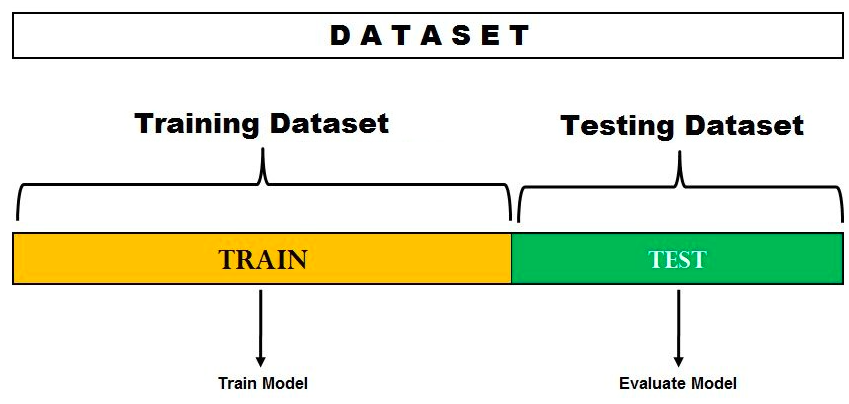

</details>

In [ ]:
# mengambil fitur/variabel masukan
X = titanic1.drop(columns = ['survived'])
y = titanic1['survived']

# membagi data menjadi data training:testing
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, #(klasifikasi pada imbalanced data) pastikan proporsi kelas di data train & test selalu sama
                                                    test_size = TEST_SIZE, #rasio data train:test = 80%:20%
                                                    random_state= RANDOM_STATE) 

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

#### Repeated Holdout

Sama halnya dengan Holdout, namun diulangi sebanyak n kali.

Misal, jika test_size = 20%, 

maka lakukan pengambilan acak terhadap 20% data sebanyak n kali untuk dijadikan sebagai data testing

Jika ingin melakukan **klasifikasi** dengan **imbalanced dataset**, maka gunakan versi yang **Stratified**

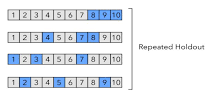

In [ ]:
# initialize ShuffleSplit splitter
rep_holdout = ShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# initialize StratifiedShuffleSplit splitter
strat_rep_holdout = StratifiedShuffleSplit(n_splits=N_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [ ]:
train_set_rephold = []
test_set_rephold = []

print('\nRepeated Holdout\n')
for i, (train_index, test_index) in enumerate(strat_rep_holdout.split(X, y)): # for strat_repeated_holdout, incl. both X and y
# for i, (train_index, test_index) in enumerate(repeated_holdout.split(X)): # for repeated_holdout, incl. X only
  print(f"Fold {i}")
  print(f"  Train: index={train_index[:5]}... ({len(train_index)} rows)")
  print(f"  Test:  index={test_index[:5]}... ({len(test_index)} rows)")
  train_set_rephold.append(train_index)
  test_set_rephold.append(test_index)



#### Cross Validation





Membagi data menjadi training:testing, namun dibagi sebanyak n-kali dengan posisi data yang menjadi data testing yang berbeda-beda

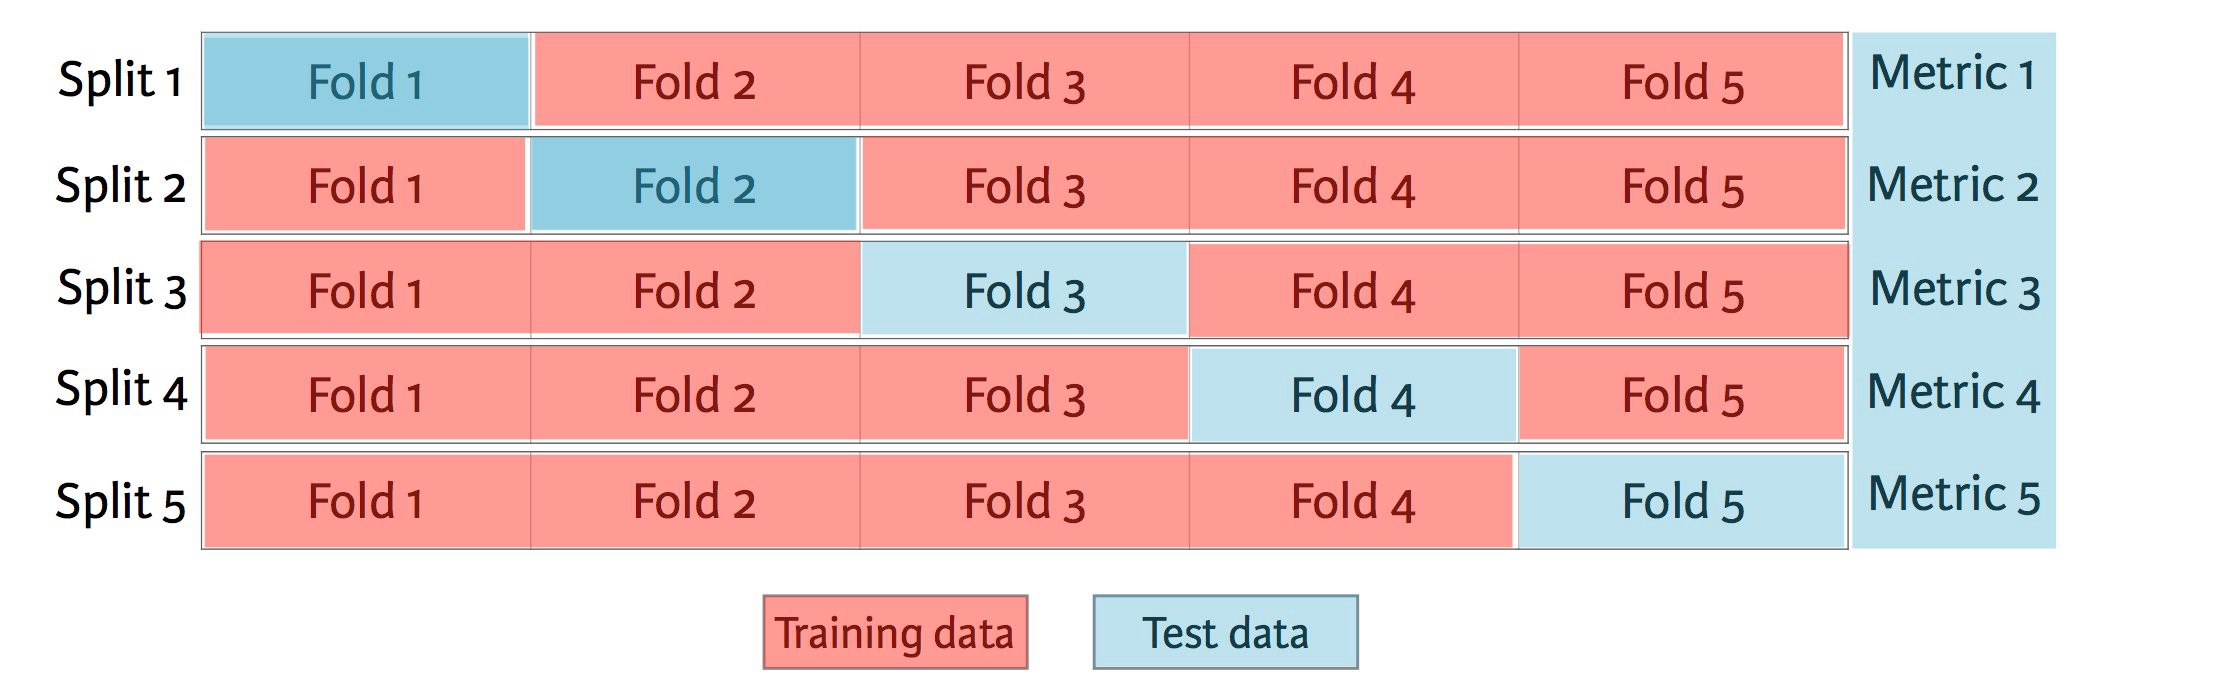

KFold merupakan library yang digunakan untuk menguji klasifikasi menggunakan metode Cross Validation. Parameter yang digunakan sebagai berikut :
* n_split : total fold yang digunakan; default = 5
* shuffle : apakah setiap fold diacak atau tidak; default = False
* random_state : digunakan apabila shuffle = True, sebagai penanda *randomness* dari setiap fold, jika tidak diisi bisa mengakibatkan nilai akurasi berubah setiap kali running

---
Sumber : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html


In [ ]:
# initialize KFold splitter 
kfold = KFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=RANDOM_STATE)

# initialize Stratified KFold splitter
strat_kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=SHUFFLE, random_state=RANDOM_STATE)

In [ ]:
train_set_kfold = []
test_set_kfold = []

print('\nKFold\n')
for i, (train_index, test_index) in enumerate(strat_kfold.split(X, y)): # for strat_kfold, incl. both X and y
# for i, (train_index, test_index) in enumerate(kfold.split(X)): # for kfold, incl. X only
  print(f"Fold {i}")
  print(f"  Train: index={train_index[:5]}... ({len(train_index)} rows)")
  print(f"  Test:  index={test_index[:5]}... ({len(test_index)} rows)")
  train_set_kfold.append(train_index)
  test_set_kfold.append(test_index)



#### Repeated Cross Validation





Sama halnya dengan Cross Validation, namun diulangi sebanyak n kali

In [ ]:
# initialize Repeated KFold splitter 
rep_kfold = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

# initialize Repeated Stratified KFold splitter 
rep_strat_kfold = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

In [ ]:
train_set_repkfold = []
test_set_repkfold = []

print('\nRepeated KFold\n')
for i, (train_index, test_index) in enumerate(rep_strat_kfold.split(X, y)): # for rep_strat_kfold, incl. both X and y
# for i, (train_index, test_index) in enumerate(rep_kfold.split(X)): # for rep_kfold, incl. X only
  print(f"Fold {i}")
  print(f"  Train: index={train_index[:5]}... ({len(train_index)} rows)")
  print(f"  Test:  index={test_index[:5]}... ({len(test_index)} rows)")
  train_set_kfold.append(train_index)
  test_set_kfold.append(test_index)

---

*Metode-metode splitting data lainnya:*
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

---

### More on Preparing the Dataset

#### Outlier treatment

*do we need to treat the outlier (on the training set) in this case?*

In [ ]:
X_train.describe()

pay attention to **"age"** and **"fare"** columns!



In [ ]:
# visualize the "age" & "fare" dist. on each "survived" class
fig, ax = plt.subplots(1, 2, figsize=(10,3))

# "age" plot
sns.scatterplot(titanic1, x='age', y='survived', ax=ax[0])
ax[0].set_title('Age vs Survived')

# "fare" plot
sns.scatterplot(titanic1, x='fare', y='survived', ax=ax[1])
ax[1].set_title('Fare vs Survived')

plt.tight_layout() # adjust spaces between subplot figures

in this case, the outliers seems occured naturally (not caused by some errors).

for this experiment, we will try to  remove only those rows with **age=80** and **fare=512**

In [ ]:
filter_fare_max = X_train['fare']==X_train['fare'].max() 
X_train[filter_fare_max]

In [ ]:
X_train.query('age == 80')

In [ ]:
# drop rows on those indices [679, 258, 630]

print(f'(before) lengh of X_train: {len(X_train)}, length of y_train: {len(y_train)}')

X_train.drop([679, 258, 630], inplace=True)
y_train.drop([679,258,630], inplace=True)

print(f'(after) lengh of X_train: {len(X_train)}, length of y_train: {len(y_train)}')

print('\nNow, the max. value of "age" is {} and "fare" is {}'.format(X_train['age'].max(), 
                                                                   X_train['fare'].max()
                                                                   ))

#### Data Balancing
(only for <u>*imbalanced*</u> data; done on **training data only**)

3 techniques in data balancing:

* **Oversampling**: RandomOversampler, SMOTE, etc.
  * https://imbalanced-learn.org/stable/references/over_sampling.html
* **Undersampling**: RandomUnderSampler, TomekLinks, etc.
  * https://imbalanced-learn.org/stable/references/under_sampling.html
* **Combination of Oversampling-Undersampling**: SMOTETomek, etc.
  * https://imbalanced-learn.org/stable/references/combine.html

In [ ]:
# check if data is imbalanced
if len(titanic1.query('survived == 0')) != len(titanic1.query('survived == 1')):
  print('it is imbalanced so needs balancing!')
  print(titanic1['survived'].value_counts(normalize=True))
else:
  print('data is balanced already!')

Perbandingan antara kelas 0 dan 1 adalah sekitar 60:40. 

Meskipun datanya tidak terlalu *imbalanced*, tapi di sini tetap kita coba *balancing*-kan

In [ ]:
from collections import Counter

print('Original dataset shape %s' % Counter(y_train))

# balancing dengan RandomOverSampler. boleh dicoba dengan metode lain e.g. SMOTE, RandomUnderSampler, TomekLinks SMOTETomek, dll.
balancer = RandomOverSampler(random_state=42)
X_train_res, y_train_res = balancer.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train_res))

#### Feature Scaling


The most common feature scaling techniques are:
* StandardScaler (based on Z-score)
* RobustScaler (based on Q1 and Q3)
* MinMaxScaler (based on Min. and Max. value) 

---

Standard Scaler, RobustScaler, vs MinMaxScaler :
https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/

Other scaler techniques : https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

Feature scaling tools in sklearn : https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

---

In titanic case, the non-categorical columns are only "age" and "fare".

Therefore, we only need to take a closer look to these columns

In [ ]:
# for example, we use StandardScaler
scaler = StandardScaler()

X_train['fare'] = scaler.fit_transform(X_train[['fare']]) # "fit" on the TRAIN set only, then transform
X_test['fare'] = scaler.transform(X_test[['fare']]) # while on the TEST set, just "transform" it

X_train['age'] = scaler.fit_transform(X_train[['age']])
X_test['age'] = scaler.transform(X_test[['age']])


### Notes on Preprocessing Steps



Urutan langkah-langkah preprocessing perlu diperhatikan karena perbedaan urutan langkah akan menghasilkan model yang berbeda pula. Misal,:
  * impute missing value pada data asli, baru splitting data
    * ataukah splitting data dulu, lalu impute missing value. maka, x_train di-impute dengan nilai mean pada x_train sendiri & x_test di-impute dengan nilai mean pada set x_test
  * outlier treatment dulu, lalu data balancing
    * ataukah data balancing dulu baru outlier treatment

Pertimbangkan alasan mengapa suatu tahap preprocessing A didahulukan daripada tahap preprocessing B

### How to evaluate classification model 

Pemilihan metrik evaluasi model tergantung dari bagaimana **definisi** kita akan **performa model yang "baik"**.

CONTOH:
* jika kita ingin melihat akurasi secara overall dan data telah seimbang, bisa menggunakan "accuracy". 
* jika kita hanya peduli terhadap prediksi dari kelas positif, maka bisa menggunakan "f1", "precision", "recall", "auc". 
* jika kita ingin melihat bagaimana prediksi dari masing2 kelas dan datanya *imbalanced*, bisa menggunakan "f1 macro" misalnya

dll.



Pada percobaan ini, kita gunakan F1-score macro sebagai acuan utama dalam mengevaluasi performa model 

> Function to summarize classification model performance

In [ ]:
def evaluator(y_test, y_pred, modelname):    
    print('Test score of {}:\n'.format(modelname))
    # Accuracy:
    print('F1-score macro is: ', f1_score(y_test,y_pred, average='macro'))
    print('')
    # Classification Report:
    print('Classification Report: \n',classification_report(y_test,y_pred))

    # untuk mengetahui confusion matrix, bisa menggunakan library classification report dengan sebelumnya melakukan proses prediksi menggunakan metode .predict
    print('Confusion Matrix: \n\n')
    plt.style.use("ggplot")
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(conf_mat = cm,figsize=(8,6),show_normed=True)

> Function untuk hyperparameter optimization

In [ ]:
def hyperparam_tuning(modelname, 
                      estimator, params, cv,
                      x_train, y_train,
                      gridsearch=False):

  print(f'\nTuning {modelname}...\n')
  
  if gridsearch == False:
    # RANDOM SEARCH
    print('\nRANDOM SEARCH\n')
    tuned_model = RandomizedSearchCV(estimator = estimator,
                                        param_distributions = params, 
                                        cv = cv, #if (int), then equals to (Stratified) k-fold, but shuffle=False
                                                #you can try kfold, strat_kfold rep_holdout, strat_rep_holdout that we defined before
                                        random_state = RANDOM_STATE,
                                        n_iter = 10, # berapa hyperparam. acak yang diambil. semakin banyak, semakin lama
                                        scoring = 'f1_macro', # get the score
                                        n_jobs=-1 # use all CPU cores
                                        )

  else: 
    # GRID SEARCH
    print('\nGRID SEARCH\n')
    tuned_model = GridSearchCV(estimator = estimator,
                                param_grid = params,
                                cv = cv, 
                                scoring = 'f1_macro',
                                n_jobs=-1
                                )

  # fitting terhadap data training  
  tuned_model.fit(x_train, y_train)
  print('\nParameter terbaik: {0} \ndengan nilai F1-score macro pada data training: {1}\n'.format(tuned_model.best_params_, tuned_model.best_score_))
  print('=============================================')

  return tuned_model

### Decision Tree

<details>
<summary>Click to view Structure of Nodes in Decision Tree</summary>

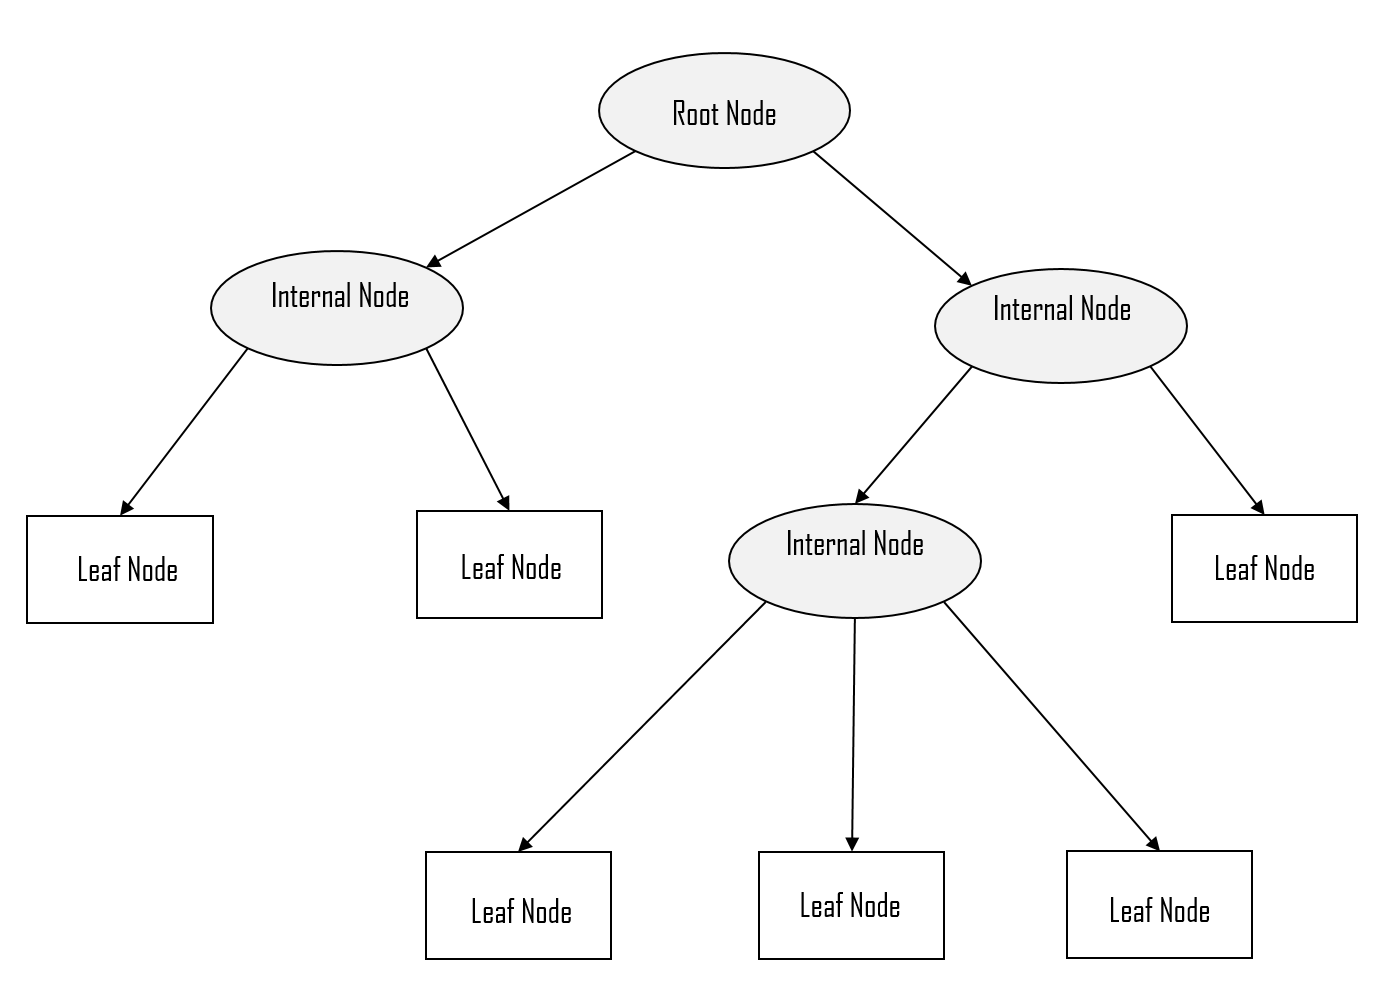
</details>

*If you're wondering how to split decision tree when you have continuous valued features:

https://www.coursera.org/learn/advanced-learning-algorithms/lecture/a4v1O/continuous-valued-features

Klasifikasi menggunakan library DecisionTreeClassifier memiliki beberapa parameter yang bisa diubah untuk menentukan metode mana yang memberikan nilai paling baik. Diantaranya :
* criterion : metode pengukuran yang menilai kualitas  *splitting* pada suatu *node*. (Kualitas ini dilihat dari tingkat ***impurity*** atau ketidakmurnian yang dihasilkan oleh *splitting* pada *node* tersebut).
  * gini (default), entropy, log_loss
* max_depth : maksimum kedalaman *node* dalam pohon
  * None (default), int
* max_features : jumlah maksimum fitur yang dipertimbangkan saat *splitting node*
  * None (default), sqrt, log2, int, float
* min_impurity_decrease : berapa setidaknya penurunan *impurity* yang harus dicapai agar suatu *node* dapat di-*split*
  * 0.0 (default), float
* min_samples_split : minimum sampel yang harus ada dalam sebuah *node* agar bisa di-*split*
  * 2 (default), int, float
* min_samples_leaf : minimum sampel yang harus ada dalam sebuah *leaf node* 
  * 1 (default), int, float
* max_leaf_nodes : berapa jumlah maksimum *leaf nodes* yang diperbolehkan
  * None (default), int
* class_weight : bobot setiap kelas, useful if you have imbalanced data
  * None (default), balanced, dict/list of dicts (eg. {1:1, 0:1})
* random_state

---


Sumber : https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
dtree = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
scoring = ['f1_macro', 'accuracy']
dtree_base_score = cross_validate(dtree, X_train_res, y_train_res, cv=strat_kfold, scoring=scoring) # using cross_validate function
dtree_base_score = pd.DataFrame(dtree_base_score)
print('Train score of Decision Tree (without Hyperparameter Tuning):\n')
print('Average of F1-score macro =',dtree_base_score['test_f1_macro'].mean())
print('Average of Accuracy =',dtree_base_score['test_accuracy'].mean())

In [ ]:
dtree_base_score

In [ ]:
# if you only need one scoring metric:
print("F1-score of each fold",cross_val_score(dtree, X_train_res, y_train_res, cv=strat_kfold, scoring="f1_macro"))
print('Average of F1-score macro:',cross_val_score(dtree, X_train_res, y_train_res, cv=strat_kfold, scoring="f1_macro").mean())

#### Hyperparameter Tuning

1. ***Grid search / exhaustive search*** : **mencoba setiap kemungkinan** dalam ruang hyperparameter lalu diambil set hyperparameter yang terbaik
2. ***Random search*** : **memilih hyperparameter secara acak** lalu diambil set hyperparameter yang terbaik

In [ ]:
dtree_params = {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, 50, None],
        'max_features':['sqrt','log2',None],
        'min_impurity_decrease': np.arange(0.0, 1.0, 0.001),
        'min_samples_split':[2, 5, 10],
        'min_samples_leaf': [1, 2, 3],
        'max_leaf_nodes': [None, 5, 10]
        }

dtree_tuned = hyperparam_tuning('Decision Tree', 
                                dtree, dtree_params, 5, #5-fold
                                X_train_res, y_train_res,
                                gridsearch=False)

#### Evaluate

In [ ]:
dtree_pred = dtree_tuned.predict(X_test)

evaluator(y_test, dtree_pred, 'Decision Tree')

> Feature Importance according to Decision Tree model

In [ ]:
dtree_feat_importance = pd.DataFrame({'feature': list(X_train_res.columns),
                                      'importance':dtree_tuned.best_estimator_.feature_importances_})
sns.barplot(dtree_feat_importance, x='feature', y='importance')
plt.title('Feature Importance (Decision Tree)')

### Random Forest

***Random Forest*** merupakan kumpulan dari sejumlah *Decision Tree* sehingga merupakan model ***ensemble***. Secara lebih spesifik, Random Forest merupakan *ensemble* yang dibangun secara paralel atau disebut dengan konsep ***bagging***. 

*Ensemble = menggabungkan beberapa model menjadi satu untuk digunakan bersamaan

Contoh bentuk *ensemble* lainnya yang dibentuk dari *Decision Tree*  yaitu **XGBoost**. Namun, XGBoost ini bukan menggunakan konsep *bagging*, melainkan ***boosting***.

---
https://www.qwak.com/post/xgboost-versus-random-forest

https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205

---

<details>
<summary> Click to view Random Forest illustration </summary>

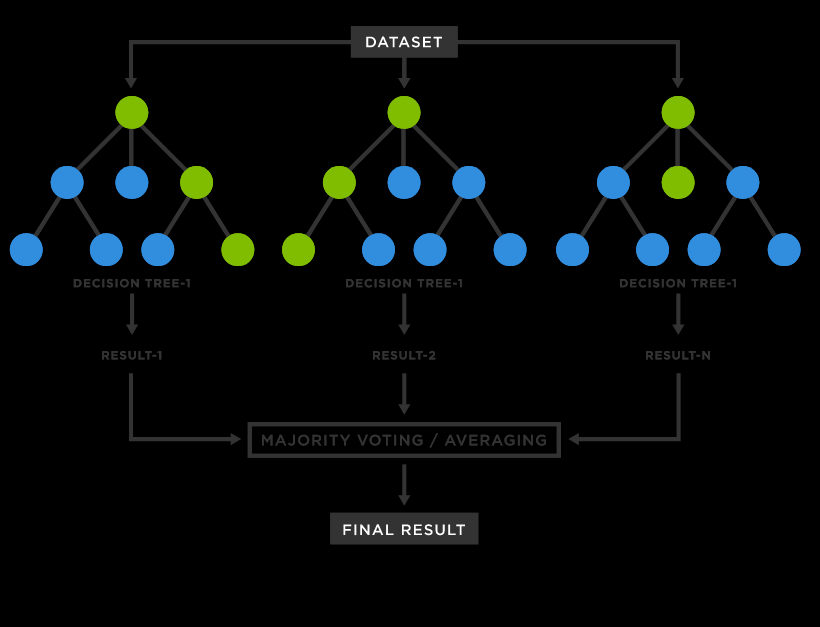

</details>

Klasifikasi menggunakan library RandomForestClassifier memiliki beberapa parameter yang bisa diubah untuk menentukan metode mana yang memberikan nilai paling baik. Diantaranya :

*criterion, max_depth, max_features, min_samples_split, min_samples_leaf, max_leaf_nodes, min_impurity_decrease, random_state (seperti pada Decision Tree)*

* n_estimators : merepresentasikan jumlah pohon yang dihasilkan
  * 100 (default), int
* max_depth : merepresentasikan kedalaman node dalam pohon
  * None (default), int
* bootstrap : 
  * True (default), False (menggunakan seluruh data training untuk membangun tiap pohonnya)
* class_weight 
  * None (default), dict/list of dicts, balanced, balanced_subsample (keseimbangan data dilihat dari sampel-sampel di tiap pohon)

---


Sumber : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
randomforest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced_subsample', bootstrap=True)

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
scoring = ['f1_macro', 'accuracy']
rf_base_score = cross_validate(randomforest, X_train_res, y_train_res, cv=strat_kfold, scoring=scoring) # using cross_validate function
rf_base_score = pd.DataFrame(rf_base_score)
print('Train score of Random Forest (without Hyperparameter Tuning):\n')
print('Average of F1-score macro =',dtree_base_score['test_f1_macro'].mean())
print('Average of Accuracy =',dtree_base_score['test_accuracy'].mean())

#### Hyperparameter Tuning

1. ***Grid search / exhaustive search*** : **mencoba setiap kemungkinan** dalam ruang hyperparameter lalu diambil set hyperparameter yang terbaik
2. ***Random search*** : **memilih hyperparameter secara acak** lalu diambil set hyperparameter yang terbaik

In [ ]:
rf_params = {
        'n_estimators':[50, 100,200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, 50, None],
        'max_features':['sqrt','log2',None],
        'min_impurity_decrease': np.arange(0.0, 1.0, 0.001),
        'min_samples_split':[2, 5, 10],
        'min_samples_leaf': [1, 2, 3],
        'max_leaf_nodes': [None, 5, 10]
        }


randomforest_tuned = hyperparam_tuning('Random Forest', 
                                randomforest, rf_params, 5, #5-fold
                                X_train_res, y_train_res,
                                gridsearch=False)

#### Evaluate

In [ ]:
rf_pred = randomforest_tuned.predict(X_test)

evaluator(y_test, rf_pred, 'Random Forest')

> Fature Importances according to Random Forest model

In [ ]:
rf_feat_importance = pd.DataFrame({'feature': list(X_train_res.columns),
                                      'importance':randomforest_tuned.best_estimator_.feature_importances_})
sns.barplot(rf_feat_importance, x='feature', y='importance')
plt.title('Feature Importance (Random Forest)')

### k-NN (k-Nearest Neighbors)


k-NN mengklasifikasikan suatu data observasi dengan melihat kelas mayoritas dari titik data yang terdekat (*neighbors*)

<details>
<summary> Click to view k-NN illustration </summary>

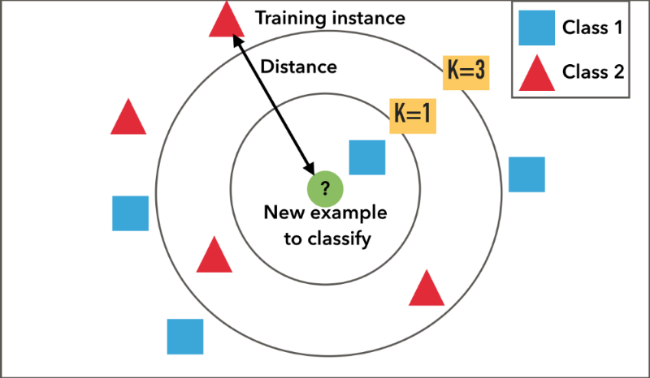

</details>

Klasifikasi menggunakan library KNeighborsClassifier memiliki beberapa parameter yang bisa diubah untuk menentukan metode mana yang memberikan nilai paling baik. Diantaranya :
* n_neighbors : berapa jumlah "tetangga" (*neighbors*) terdekat yang dipertimbangkan untuk menentukan kelas dari suatu observasi
  * 5 (default), int
* weights : mengatur bobot *neighbors*
  * uniform (default), distance (*neighbor* yang dekat akan diberi bobot lebih besar)
* p : parameter untuk metrik Minkowski
  * 2 (default, ini artinya 'l2' atau *euclidean distance*), 1 (sama dengan 'l1' atau *manhattan distance*)

---


Sumber : https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [ ]:
knn = KNeighborsClassifier()

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
scoring = ['f1_macro', 'accuracy']
knn_base_score = cross_validate(knn, X_train_res, y_train_res, cv=strat_kfold, scoring=scoring) # using cross_validate function
knn_base_score = pd.DataFrame(knn_base_score)
print('Train score of KNN (without Hyperparameter Tuning):\n')
print('Average of F1-score macro =',knn_base_score['test_f1_macro'].mean())
print('Average of Accuracy =',knn_base_score['test_accuracy'].mean())

Below is an example if you want to try out the Repeated Stratified KFold :

In [ ]:
temp_X = X_train_res.reset_index(drop=True)
temp_y = y_train_res.reset_index(drop=True)
temp_f1scores = []

for i, (train_index, valid_index) in enumerate(rep_strat_kfold.split(temp_X, # try to change the "rep_strat_kfold" with rep_kfold / rep_holdout / strat_rep_holdout / kfold / strat_kfold 
                                                                     temp_y)):
  print('Fold: ',i)

  knn.fit(temp_X.iloc[train_index], 
          temp_y.iloc[train_index])
  
  pred_temp = knn.predict(temp_X.iloc[valid_index])

  tempf1score = f1_score(temp_y.iloc[valid_index], 
                          pred_temp, 
                          average='macro')
  
  temp_f1scores.append(tempf1score)

  print('F1-score macro: ',  tempf1score)

print('Average of F1-score macro: ', np.array(temp_f1scores).mean())

#### Hyperparameter Tuning

1. ***Grid search / exhaustive search*** : **mencoba setiap kemungkinan** dalam ruang hyperparameter lalu diambil set hyperparameter yang terbaik
2. ***Random search*** : **memilih hyperparameter secara acak** lalu diambil set hyperparameter yang terbaik

In [ ]:
knn_params = {
        'n_neighbors':np.arange(1,5+1),
        'weights':['uniform','distance'],
        'p':[1,2]
        }


knn_tuned = hyperparam_tuning('KNN', 
                                knn, knn_params, 5, #5-fold
                                X_train_res, y_train_res,
                                gridsearch=True)

#### Evaluate

In [ ]:
knn_pred = knn_tuned.predict(X_test)

evaluator(y_test, knn_pred, 'KNN')

### Naive Bayes

Naive Bayes merupakan algoritma yang bersifat "probabilistik"

<details>
<summary> Click to view Naive Bayes explanation </summary>

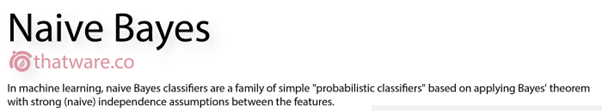

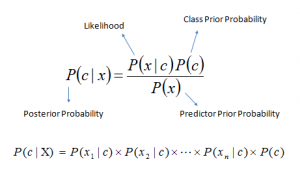

</details>

Umumnya, model Naive Bayes ini dibangun menggunakan GaussianNB

Namun, pada kasus tertentu, misal: 
  * klasifikasi teks menggunakan MultinomialNB
  * jika data kategorikal, bisa dengan CategoricalNB

Luckily, you don't need to do hyperparameter tuning for Naive Bayes!

---
https://scikit-learn.org/stable/modules/naive_bayes.html#

In [ ]:
naivebayes = GaussianNB()

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
scoring = ['f1_macro', 'accuracy']
nb_base_score = cross_validate(naivebayes, X_train_res, y_train_res, cv=strat_kfold, scoring=scoring) # using cross_validate function
nb_base_score = pd.DataFrame(nb_base_score)
print('Train score of Naive Bayes (without Hyperparameter Tuning):\n')
print('Average of F1-score macro =',nb_base_score['test_f1_macro'].mean())
print('Average of Accuracy =',nb_base_score['test_accuracy'].mean())

In [ ]:
# directly fit Naive Bayes to Train set
naivebayes.fit(X_train_res, y_train_res)

#### Evaluate

In [ ]:
nb_pred = naivebayes.predict(X_test)

evaluator(y_test, nb_pred, 'Naive Bayes')

### SVM (Support Vector Machine)

*SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data are transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.* 

"How SVM works?" 
https://www.ibm.com/docs/en/spss-modeler/saas?topic=models-how-svm-works

https://www.analyticsvidhya.com/blog/2021/03/beginners-guide-to-support-vector-machine-svm/

<details>
<summary> Click to view SVM illustration </summary>

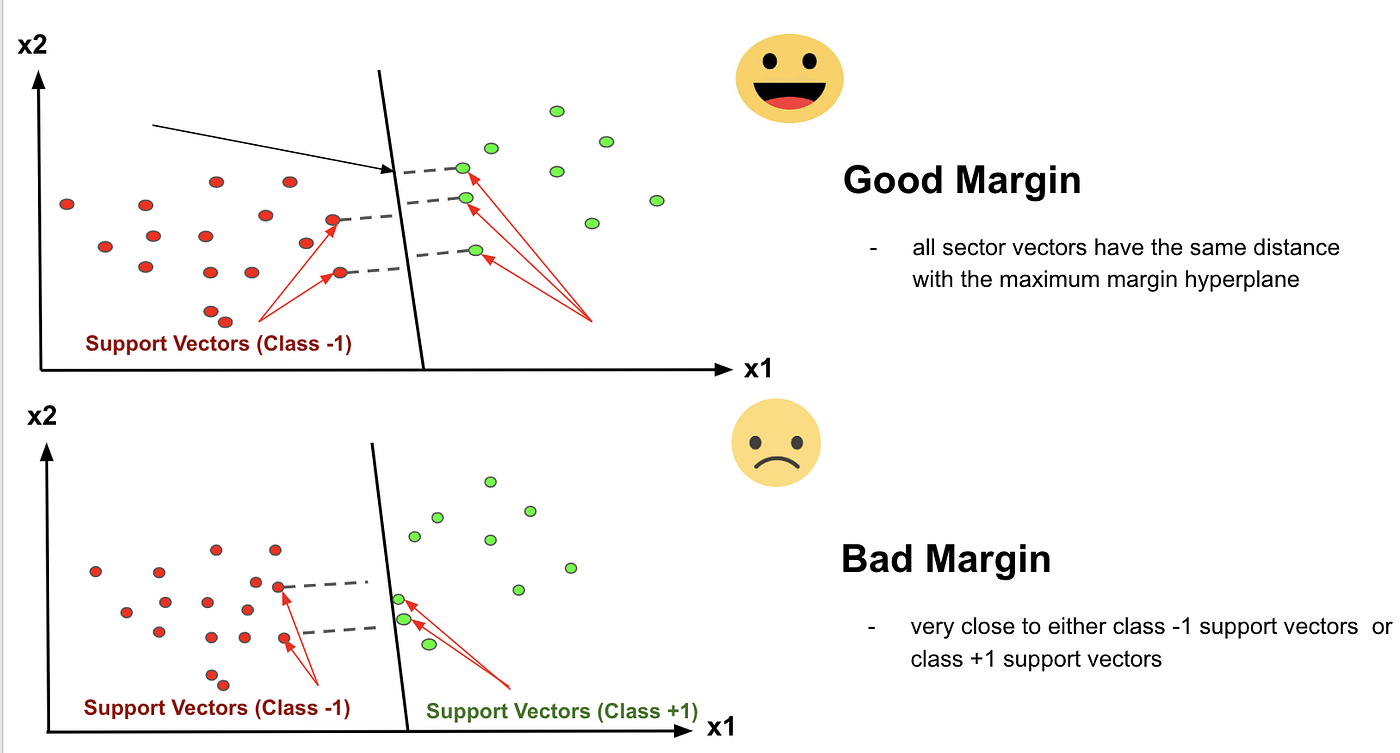

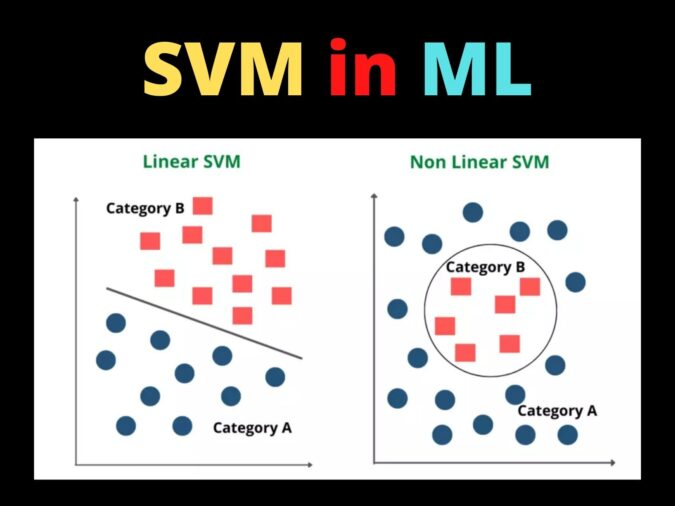


</details>

Note :
Semakin banyak datanya, maka training time SVM semakin lama. Hal ini dikarenakan SVM **perlu menelusuri setiap titik data untuk menentukan *support vectors* dan *decision boundary*** (*hyperplane*: high dimensional dec. boundary) yang dapat memisahkan kelas-kelas dengan baik.

Untuk klasifikasi menggunakan SVM, umumnya memakai SVC. Sementara itu, beberapa jenis classifier SVM lainnya pada sklearn, terdapat LinearSVC (SVM dengan fokus pada kernel linear saja; good option if data is linearly separable) dan NuSVC (SVM yang dapat diatur jumlah support vector-nya agar waktu training lebih cepat).

Hyperparameter pada SVC:
* kernel : fungsi kernel SVM apa yang ingin digunakan
  * rbf (default), linear, poly, sigmoid
* C : parameter regularisasi. semakin kecil C, semakin kuat regularisasinya, sehingga semakin besar misklasifikasi-nya.
  * 1.0 (default), float
* degree : derajat polinomial jika menggunakan kernel poly
  * 3 (default)
* gamma : koefisien khusus kernel rbf, poly, dan sigmoid. Gamma mengatur kelengkungan (*curvature*) garis *dec. boundary*. Semakin kecil gamma, maka semakin kurang menangkap bentuk dari data.
  * scale (default), auto, float
* probability : untuk menghasilkan prediksi dalam bentuk nilai probabilitas 
  * False (default), True
* class_weight : mengatur bobot setiap kelas
  * None (default), balanced, dict
* random_state
  * None (default), int
---

Sumber : 
* Tuning SVM https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
* C vs Gamma https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
* SVM kernel https://techvidvan.com/tutorials/svm-kernel-functions/
* https://scikit-learn.org/stable/modules/svm.html
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [ ]:
# Klasifikasi SVM menggunakan Cross Validation
svm = SVC(class_weight='balanced', random_state=RANDOM_STATE, probability=False)

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
scoring = ['f1_macro', 'accuracy']
svm_base_score = cross_validate(svm, X_train_res, y_train_res, cv=strat_kfold, scoring=scoring) # using cross_validate function
svm_base_score = pd.DataFrame(svm_base_score)
print('Train score of SVM (without Hyperparameter Tuning):\n')
print('Average of F1-score macro =',svm_base_score['test_f1_macro'].mean())
print('Average of Accuracy =',svm_base_score['test_accuracy'].mean())

#### Hyperparameter Tuning

1. ***Grid search / exhaustive search*** : **mencoba setiap kemungkinan** dalam ruang hyperparameter lalu diambil set hyperparameter yang terbaik
2. ***Random search*** : **memilih hyperparameter secara acak** lalu diambil set hyperparameter yang terbaik

In [ ]:
svm_params = {
        'kernel': ['rbf','linear','poly','sigmoid'],
        }


svm_tuned = hyperparam_tuning('SVM', 
                                svm, svm_params, 5, #5-fold
                                X_train_res, y_train_res,
                                gridsearch=True)

#### Evaluate

In [ ]:
svm_pred = svm_tuned.predict(X_test)

evaluator(y_test, svm_pred, 'SVM')

### Logistic Regression

Logistic Regression digunakan untuk memprediksi probabilitas dari suatu kejadian berdasarkan nilai variabel independen. Dikarenakan output-nya berupa probabilitas, maka nilainya antara 0 dan 1. Umumnya digunakan threshold=0.5, yakni if x >= 0.5 then class 1, else class 0.

---
What is Logistic Regression? https://www.ibm.com/topics/logistic-regression

Why can't we just use Linear Regression for classification? https://ai.plainenglish.io/why-cant-we-use-linear-regression-to-solve-a-classification-problem-68edf1a3261b

sklearn doc. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

---

<details>
<summary> Click to view Logistic Regression image</summary>

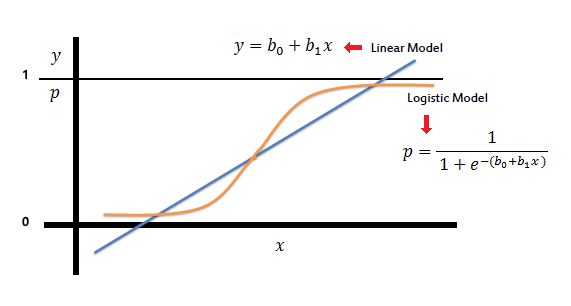

</details>

Kita bisa gunakan LogisticRegression dari sklearn

Beberapa hyperparameter dari Logistic Regression:
* penalty : metode penalti/regularisasi
  * l2 (default), l1, elasticnet (both l1 & l2 are added), None
* C : parameter regularisasi. semakin kecil C, semakin kuat regularisasinya, semakin besar penalti yang diberkan jika terlalu banyak variabel yang digunakan.
  * 1.0 (default), float
* solver : algoritma optimisasi yg dipakai
  * lbfgs (default), liblinear, newton-cg, newton-cholesky, sag, saga
* class_weight : bobot kelas
  * None (default), balanced
* random_state
  * None (default), int, RandomState instance

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
logreg = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
scoring = ['f1_macro', 'accuracy']
logreg_base_score = cross_validate(logreg, X_train_res, y_train_res, cv=strat_kfold, scoring=scoring) # using cross_validate function
logreg_base_score = pd.DataFrame(logreg_base_score)
print('Train score of Logistic Regression (without Hyperparameter Tuning):\n')
print('Average of F1-score macro =',logreg_base_score['test_f1_macro'].mean())
print('Average of Accuracy =',logreg_base_score['test_accuracy'].mean())

#### Hyperparameter Tuning

1. ***Grid search / exhaustive search*** : **mencoba setiap kemungkinan** dalam ruang hyperparameter lalu diambil set hyperparameter yang terbaik
2. ***Random search*** : **memilih hyperparameter secara acak** lalu diambil set hyperparameter yang terbaik

In [ ]:
logreg_params = {
        'penalty':['l2','l1','elasticnet'],
        'C':[1,2,3,4,5],
        'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
        }


logreg_tuned = hyperparam_tuning('Logistic Regression', 
                                logreg, logreg_params, 5, #5-fold
                                X_train_res, y_train_res,
                                gridsearch=True)

#### Evaluate

In [ ]:
logreg_pred = logreg_tuned.predict(X_test)

evaluator(y_test, logreg_pred, 'Logistic Regression')

We can also do threshold-tuning, instead of using 0.5 as default threshold

e.g. getting the best threshold from ROC curve (based on True Positive Rate & False Positive Rate), or using Precision-Recall curve

---

Source : https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/


In [ ]:
# roc curve for logistic regression model with optimal threshold

# we need the predict probabilities of Log. Reg.
logreg_predprob = logreg_tuned.predict_proba(X_test)[:,1] # take predprob for the class 1 only

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, logreg_predprob)

# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('\nBest Threshold=%f \n' % (best_thresh))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

### Neural Network



*Neural network* (NN) merupakan algoritma yang terinspirasi dari sistem saraf manusia, yakni terdiri dari **banyak *neuron*** dan **suatu *neuron* akan diaktivasi oleh *neuron* lainnya yang saling terhubung**. 

Tiap neuron tersebut sebenarnya merupakan model ***linear regression*** yang terdiri atas **bobot (w) dan bias (b) yang dimasukkan ke dalam sebuah fungsi aktivasi**, lalu jika hasil nilainya melebihi sebuah ***threshold***, maka akan diteruskan ke neuron lainnya. 

Cara melatih model NN ini yaitu dengan **secara iteratif meng-update bobot dan bias** sedemikian rupa sehingga dapat menghasilkan prediksi yang tepat.

---

*What are neural networks?* 
https://www.ibm.com/topics/neural-networks

---

<details>
<summary>Click to view image of Neural Networks</summary>

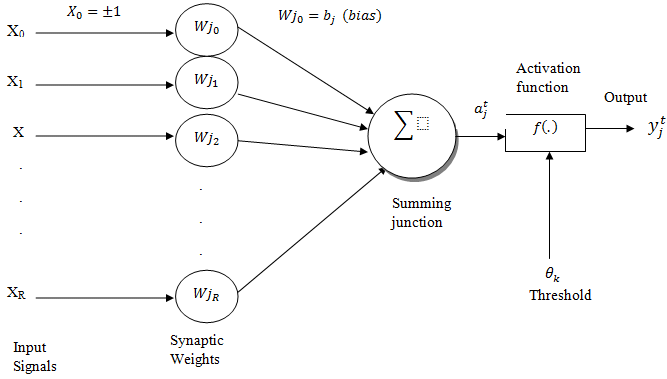

</details>

Neural network inilah yang menjadi **cikal bakal dari bidang *Deep Learning***. Deep Learning merupakan Neural Network yang terdiri atas >=3 layer.

Kelebihan deep learning: mengotomasi proses ekstraksi fitur. oleh sebab itu, banyak digunakan dalam mengekstraksi fitur pada data yang *unstructured* seperti gambar, video, suara, teks

---

*What is deep learning?* 
https://www.ibm.com/id-en/topics/deep-learning

---

Kita coba implementasikan NN menggunakan library TensorFlow

Beberapa hyperparameter NN yang bisa diatur:
* Jumlah **node di dalam hidden layer (*hidden units*)** 
* Jumlah **epoch** (berapa kali model ingin dilatih terhadap keseluruhan data training)
* **Fungsi aktivasi** e.g. relu, softmax, sigmoid, tanh, softsign
* Jenis **optimizer** e.g. adam, rmsprop, sgd
* Ukuran batch (**batch size**) yang berfungsi mengatur berapa banyak data dalam 1 iterasi yang digunakan untuk meng-update parameter bobot dan bias. Dalam 1 epoch, terdapat n iterasi, contoh: 100 baris data dengan batch_size=10 sampel, maka akan ada 10 iterasi/epoch

---

*How to choose the number of hidden units?*
https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

*Types of activation function* https://www.v7labs.com/blog/neural-networks-activation-functions

*Intuitive explanation of common optimizers* https://dropsofai.com/optimizers-explained-for-training-neural-networks/

---


#### Training 

For the sake of technical simplicity, we don't do Gridsearch / Randomsearch on this tensorflow NN model. 

We will set the hyperparameters manually.

In reality, some of the most challenging parts of building an NN or Deep Learning model are : 
* designing its architecture 
* hyperparameter optimization.

In [ ]:
# set hyperparameters. you may change these later to see the effect on model performance.
INPUT_DIM = X.shape[1]
HIDDEN_UNITS = 4  # following one of many rule-of-thumbs, where n_hidden is between n_features & n_output
HIDDEN_ACTIVATION = 'relu'
OUTPUT = 1
OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=0.001)
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
# define tensorflow-keras Neural Network model
nn_model = Sequential([
    Dense(HIDDEN_UNITS, activation=HIDDEN_ACTIVATION, input_dim=INPUT_DIM),
    Dense(OUTPUT, activation='sigmoid')
    ])

# compile the model
nn_model.compile(optimizer = OPTIMIZER, 
              loss='binary_crossentropy', #this loss is specific for binary classification only
              metrics = ['accuracy'])

Here, we will also use some callbacks:
* Earlystopping : earlystopping the training if the score is no longer changing significantly. It can reduce overfitting
                                                        
* ModelCheckpoint : to save checkpoints (training history). it is helpful, esp. when the training stops abruptly, we can just restore the checkpoints and continue the training again. alternatively, we also can **save the best checkpoint only** (checkpoint with highest accuracy / lowest loss)

In [ ]:
# train the model
tf.random.set_seed(RANDOM_STATE) #set random seed

es_callback = EarlyStopping(monitor='loss', patience=5) #patience=5 means "let's wait until the next 5 epochs, maybe the loss would be decreasing"

# Create a callback that saves the best model only
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/checkpoint",
                                                 monitor = 'val_loss',
                                                 save_best_only=True,
                                                 verbose=1)

history = nn_model.fit(X_train_res, y_train_res,
                      validation_data=(X_test, y_test),
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=[es_callback, cp_callback]
                       )

#### Evaluate

In [ ]:
def plot_history_nn(which_score):
  plt.plot(history.history[which_score], label='training', color='blue')
  plt.plot(history.history['val_'+which_score], label='validation', color='red')
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel(which_score)
  plt.title('History of {}'.format(which_score))

In [ ]:
plot_history_nn('loss')

In [ ]:
plot_history_nn('accuracy')

In [ ]:
# load weights from the best checkpoint
nn_model.load_weights('/content/checkpoint')

print('Best model NN:')
nn_model.evaluate(X_test, y_test)

In [ ]:
# after loading the best weights, now save your NN model
nn_model.save('nn_model')

<details> 
<summary>Checkpoints vs Saved model on TensorFlow?</summary>

*Checkpoints capture the exact value of all parameters (tf.Variable objects) used by a model. Checkpoints do not contain any description of the computation defined by the model.*

*The SavedModel format on the other hand includes a serialized description of the computation defined by the model in addition to the parameter values (checkpoint). Models in this format are independent of the source code that created the mode*

---

Source: https://stackoverflow.com/questions/60532373/saving-model-checkpoint-vs-saving-entire-model-in-keras

</details>

In [ ]:
nn_pred = nn_model.predict(X_test) # the result is still in probabilities (just like predproba)
nn_pred = np.where(nn_pred>=0.5, 1, 0)
evaluator(y_test, nn_pred, "Neural Networks")

### Model Analysis

Referensi notebook dari Kaggle untuk mencapai 99% accuracy pada dataset Titanic

https://www.kaggle.com/code/sushanpatel/titanic-dataset-accuracy-99#Using-Logistic-Regression-Algorithm

In [ ]:
# record the model performance
def get_f1_macro(y_test, model_pred):
  return f1_score(y_test, model_pred, average='macro')

dtree_f1 = get_f1_macro(y_test, dtree_pred)
randomforest_f1 = get_f1_macro(y_test, rf_pred)
knn_f1 = get_f1_macro(y_test, knn_pred)
naivebayes_f1 = get_f1_macro(y_test, nb_pred)
svm_f1 = get_f1_macro(y_test, svm_pred)
logreg_f1 = get_f1_macro(y_test, logreg_pred)
nn_f1 = get_f1_macro(y_test, nn_pred)

In [ ]:
# store the model performance in a table
model_name = ['Decision Tree', "Random Forest", 'KNN', 'Naive Bayes', 'SVM', 'Logistic Regression', 'Neural Network']
model_score = [dtree_f1, randomforest_f1, knn_f1, naivebayes_f1, svm_f1, logreg_f1, nn_f1]

model_performance = pd.DataFrame({'Model':model_name,
                                  'F1-score macro':model_score})
model_performance = model_performance.sort_values("F1-score macro", ascending = False)

In [ ]:
# visualize model performance
fig, ax = plt.subplots()
bars = ax.barh(model_performance['Model'], model_performance['F1-score macro'])
ax.bar_label(bars)
plt.xlabel('F1-score macro')

## Regresi

### Preparing Data

In [ ]:
# Load Data
tips_data = sns.load_dataset("tips")
tips_data

In [ ]:
# Cek Data apakah ada yang null
tips_data.isnull().sum()

In [ ]:
# Cek tipe data
tips_data.info()


    The waiter collected several variables: 
    The tip in dollars, 
    the bill in dollars, 
    the sex of the bill payer, 
    whether there were smokers in the party, 
    the day of the week, 
    the time of day, and
    the size of the party.

In [ ]:
# Cek nilai unik pada kolom yang kategorikal
categorical_columns = []
for cols in list(tips_data.columns):
  if tips_data[cols].dtype not in ['float','int']:
    categorical_columns.append(cols)

print('\nUnique values in Categorical columns\n')
for catg_cols in categorical_columns:
  print(f'{catg_cols}: {tips_data[catg_cols].unique()}\n')

> Exploratory Data Analysis

In [ ]:
# Cek distribusi nilai kategorik dengan value_counts()
print('\nValue Counts in Categorical columns:\n')
for catg_cols in categorical_columns+['size']:
  print(f'{catg_cols}: {tips_data[catg_cols].value_counts()}\n')

In [ ]:
tips_data.describe()

In [ ]:
# cek perbandingan total bill dengan tip yang diberikan
tips_data.plot(x='total_bill', y='tip', style='o')  
plt.title('total_bill vs tip')  
plt.xlabel('total_bill')  
plt.ylabel('tip')  
plt.show()

In [ ]:
# cek sebaran nilai "tip" jika dikategorikan terhadap "time", "day", "sex", "smoker"
fig, ax = plt.subplots(2, 5, figsize=(12,5))

sns.kdeplot(data=tips_data, x='tip', hue='time', ax = ax[0,0])
sns.kdeplot(data=tips_data, x='tip', hue='day', ax = ax[0,1])
sns.kdeplot(data=tips_data, x='tip', hue='sex', ax = ax[0,2])
sns.kdeplot(data=tips_data, x='tip', hue='smoker', ax = ax[0,3])
sns.kdeplot(data=tips_data, x='tip', hue='size', ax = ax[0,4])

sns.boxplot(data=tips_data, x='time', y='tip', ax = ax[1,0])
sns.boxplot(data=tips_data, x='day', y='tip',  ax = ax[1,1])
sns.boxplot(data=tips_data, x='sex', y='tip',  ax = ax[1,2])
sns.boxplot(data=tips_data, x='smoker', y='tip', ax = ax[1,3])
sns.boxplot(data=tips_data, x='size', y='tip', ax = ax[1,4])
plt.tight_layout()

In [ ]:
# semakin besar party size, semakin banyak tip yang diberikan
sns.scatterplot(data=tips_data, x='total_bill', y='tip', hue='size')
plt.title('Total bill vs Tip vs Party Size')

> Categorical encoding

In [ ]:
tips = tips_data.copy() # copy tips_data to a new variable to keep the original data

In [ ]:
# categorical encoding using pandas.factorize()
tips_labelencode = tips[['sex','smoker','time']].apply(lambda x: pd.factorize(x)[0])
tips_day_onehotencode = pd.Series(np.where(tips['day']=='Thur',0,1), name='day') # Thur --> weekday (0) | Fri, Sat, Sun --> weekend(1)
tips = pd.concat([ tips_labelencode, 
                    tips_day_onehotencode,
                    tips[['size','total_bill','tip']]
                  ], axis=1)
tips.columns = map(str.lower, tips.columns)
tips

> Melihat korelasi antar fitur

In [ ]:
# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(tips.corr('spearman'),annot=True)

Correlated features ( >= 0.75 ): 
  * day vs TIME

Hapus kolom "day" karena "time" lebih berkorelasi terhadap kolom target "tip"

In [ ]:
tips.drop(columns='day', inplace=True)

> Train-Test split


In [ ]:
X = tips.drop(columns = "tip")
y = tips['tip']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

> Feature Scaling

We will only scale **total_bill**

In [ ]:
scaler = StandardScaler()
x_train['total_bill'] = scaler.fit_transform(x_train[['total_bill']]) #fit on train set
x_test['total_bill'] = scaler.transform(x_test[['total_bill']]) #transform on test set

In [ ]:
x_train.describe()

> Evaluation 

We will use MSE as the main metric

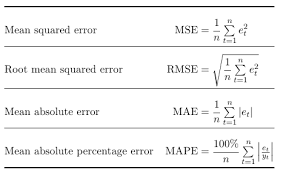

In [ ]:
# function untuk crossval pada baseline model
def crossval_train_regression(x_train, y_train, modelestimator, model_name):
  print(f'\nTrain score of {model_name}:\n')
  print("MSE of each fold",cross_val_score(modelestimator, x_train, y_train, cv=kfold, scoring="neg_mean_squared_error")*-1)
  print('Average of MSE :',cross_val_score(modelestimator, x_train, y_train, cv=kfold, scoring="neg_mean_squared_error").mean()*-1)

In [ ]:
# function untuk hyperparam. tun. regression model (ubah scoring jadi MSE)
def hyperparam_tuning(modelname, 
                      estimator, params, cv,
                      x_train, y_train,
                      gridsearch=False):

  print(f'\nTuning {modelname}...\n')
  
  if gridsearch == False:
    # RANDOM SEARCH
    print('\nRANDOM SEARCH\n')
    tuned_model = RandomizedSearchCV(estimator = estimator,
                                        param_distributions = params, 
                                        cv = cv, #if (int), then equals to (Stratified) k-fold, but shuffle=False
                                                #you can try kfold, strat_kfold rep_holdout, strat_rep_holdout that we defined before
                                        random_state = RANDOM_STATE,
                                        n_iter = 10, # berapa hyperparam. acak yang diambil. semakin banyak, semakin lama
                                        scoring = 'neg_mean_squared_error', # get the score
                                        n_jobs=-1 # use all CPU cores
                                        )

  else: 
    # GRID SEARCH
    print('\nGRID SEARCH\n')
    tuned_model = GridSearchCV(estimator = estimator,
                                param_grid = params,
                                cv = cv, 
                                scoring = 'neg_mean_squared_error',
                                n_jobs=-1
                                )

  # fitting terhadap data training  
  tuned_model.fit(x_train, y_train)
  print('\nParameter terbaik: {0} \ndengan nilai MSE pada data training: {1}\n'.format(tuned_model.best_params_, tuned_model.best_score_*-1))
  print('=============================================')

  return tuned_model

In [ ]:
def evaluate_regression(y_test, model_pred, model_name):
  print('\nTest score of {}:\n'.format(model_name)) 
  print('Mean Squared Error - Test:', metrics.mean_squared_error(y_test, model_pred))  
  print('Mean Absolute Error - Test:', metrics.mean_absolute_error(y_test, model_pred)) 
  print('Root Mean Squared Error - Test:', np.sqrt(metrics.mean_squared_error(y_test, model_pred)))
  print()

  #visualize y_test vs predicted value
  plt.plot(x_test['total_bill'], y_test, 'o', label='actual')
  plt.plot(x_test['total_bill'], model_pred, 'x', label='predicted')
  plt.legend()
  plt.xlabel('total_bill')
  plt.ylabel('tip')
  plt.title(model_name+' prediction')

### Linear Regression

In [ ]:
linreg = LinearRegression()

Untuk melakukan prediksi menggunakan regresi linear, menggunakan library LinearRegression()


---


Sumber : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [ ]:
# cross val score on train set
crossval_train_regression(x_train, y_train, linreg, 'Linear Regression')

In [ ]:
# train model, then predict
linreg.fit(x_train, y_train)
linreg_pred = linreg.predict(x_test)

evaluate_regression(y_test, linreg_pred, 'Linear Regression')

### Random Forest Regressor

Hyperparameternya hampir sama dengan RandomForestClassifier, hanya saja yang berbeda yaitu:
  * criterion: “squared_error” (default), “absolute_error”, “friedman_mse”, “poisson”

---
sklearn RF regressor https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

(Regression in Decision Tree) https://www.coursera.org/lecture/advanced-learning-algorithms/regression-trees-optional-XlM5n

In [ ]:
# Melakukan prediksi menggunakan regresi
randomforest_regression = RandomForestRegressor(random_state=RANDOM_STATE)

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
# cross val score on train set
crossval_train_regression(x_train, y_train, randomforest_regression, 'Random Forest Regression')

In [ ]:
# train model, then predict
randomforest_regression.fit(x_train, y_train)
rf_regres_pred = randomforest_regression.predict(x_test)

evaluate_regression(y_test, rf_regres_pred, 'Random Forest Regression')

#### Hyperparameter Tuning

1. ***Grid search / exhaustive search*** : **mencoba setiap kemungkinan** dalam ruang hyperparameter lalu diambil set hyperparameter yang terbaik
2. ***Random search*** : **memilih hyperparameter secara acak** lalu diambil set hyperparameter yang terbaik

In [ ]:
rf_regres_params = {
        'n_estimators':[50, 100,200],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        'max_depth': [10, 20, 50, None],
        'max_features':['sqrt','log2',None],
        'min_impurity_decrease': np.arange(0.0, 1.0, 0.001),
        'min_samples_split':[2, 5, 10],
        'min_samples_leaf': [1, 2, 3],
        'max_leaf_nodes': [None, 5, 10]
        }

rf_regres_tuned = hyperparam_tuning('Random Forest Regression', 
                                    randomforest_regression, rf_regres_params, 5, #5-fold
                                    x_train, y_train,
                                    gridsearch=False)

#### Evaluate

In [ ]:
rf_regres_pred = rf_regres_tuned.predict(x_test) # predict

evaluate_regression(y_test, rf_regres_pred, 'Random Forest Regression') #evaluate

> Fature Importances according to Random Forest model

In [ ]:
rf_regres_feat_importance = pd.DataFrame({'feature': list(x_train.columns),
                                      'importance':rf_regres_tuned.best_estimator_.feature_importances_})
sns.barplot(rf_regres_feat_importance, x='feature', y='importance')
plt.title('Feature Importance (Random Forest Regression)')

### SVR

Hyperparameternya hampir sama dengan SVC, hanya saja yang berbeda yaitu:
  * epsilon: mengatur luas area *epsilon-tube*, yang mana titik data di dalam  area tsb. tidak akan dihitung sebagai error.
    * 0.1 (default), float

---
sklearn RF regressor https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

(Regression in Decision Tree) https://www.coursera.org/lecture/advanced-learning-algorithms/regression-trees-optional-XlM5n

<details>
<summary> Click to view image of SVR vs SVC </summary>

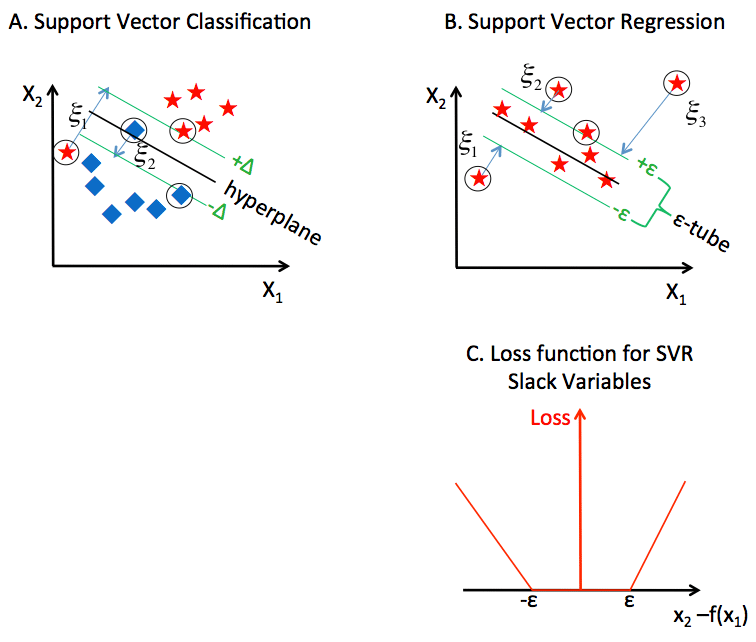

</details>

In [ ]:
svr = SVR()

#### Without Hyperparam. Tuning

First of all, **check** the **baseline of model performance** before hyperparameter tuning using **Cross Val.**, instead of just using 1-fold of Train-Test split (aka. Holdout). 

This is done in order to produce more **robust estimation of model performance**. Because, by using Cross. val., we will have more Train-Test folds to try out.

In [ ]:
# cross val score on train set
crossval_train_regression(x_train, y_train, svr, 'Support Vector Regression')

#### Hyperparameter Tuning

1. ***Grid search / exhaustive search*** : **mencoba setiap kemungkinan** dalam ruang hyperparameter lalu diambil set hyperparameter yang terbaik
2. ***Random search*** : **memilih hyperparameter secara acak** lalu diambil set hyperparameter yang terbaik

In [ ]:
svr_params = {
        'kernel': ['rbf','linear','poly','sigmoid'],
        'C':[0.8,1,2,3],
        'epsilon':[0.1,0.2,0.3]
        }

svr_tuned = hyperparam_tuning('Support vector regression', 
                              svr, svr_params, 5, #5-fold
                              x_train, y_train,
                              gridsearch=False)

#### Evaluate

In [ ]:
svr_pred = svr_tuned.predict(x_test) # predict

evaluate_regression(y_test, svr_pred, 'Support Vector Regression') #evaluate

### Neural Network

Untuk Neural Network, hanya perlu mengubah activation pada output layer menjadi "linear"

In [ ]:
!rm -r checkpoint # hapus checkpoint sebelumnya
!rm -r nn_model # hapus nn model sebelumnya
del nn_model

In [ ]:
x_train.shape

In [ ]:
# set hyperparameters. you may change these later to see the effect on model performance.
INPUT_DIM = x_train.shape[1]
HIDDEN_UNITS = 3  # following one of many rule-of-thumbs, where n_hidden is between n_features & n_output
HIDDEN_ACTIVATION = 'relu'
OUTPUT = 1
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
EPOCHS = 100
BATCH_SIZE = 32

In [ ]:
# define tensorflow-keras Neural Network model
nn_model = Sequential([
    Dense(HIDDEN_UNITS, activation=HIDDEN_ACTIVATION, input_dim=INPUT_DIM),
    Dense(OUTPUT, activation='linear')
    ])

# compile the model
nn_model.compile(optimizer = OPTIMIZER, 
              loss='mean_squared_error' #this loss is specific for regression only
              )

In [ ]:
# train the model
tf.random.set_seed(RANDOM_STATE) #set random seed

es_callback = EarlyStopping(monitor='loss', patience=5) #patience=5 means "let's wait until the next 5 epochs, maybe the loss would be decreasing"

# Create a callback that saves the best model only
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="/content/checkpoint",
                                                 monitor = 'val_loss',
                                                 save_best_only=True,
                                                 verbose=1)

history = nn_model.fit(x_train, y_train,
                      validation_data=(x_test, y_test),
                      epochs=EPOCHS,
                      batch_size=BATCH_SIZE,
                      callbacks=[es_callback, cp_callback]
                       )

In [ ]:
def plot_history_nn(which_score):
  plt.plot(history.history[which_score], label='training', color='blue')
  plt.plot(history.history['val_'+which_score], label='validation', color='red')
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel(which_score)
  plt.title('History of {}'.format(which_score))

In [ ]:
plot_history_nn('loss')

In [ ]:
# load weights from the best checkpoint
nn_model.load_weights('/content/checkpoint')

print('Best model NN:')
nn_model.evaluate(x_test, y_test)

In [ ]:
nn_pred = nn_model.predict(x_test) # the result is still in probabilities (just like predproba)

evaluate_regression(y_test, nn_pred, "Neural Networks (Regression)")

### Model Analysis

In [ ]:
# record the model performance
def get_MSE(y_test, model_pred):
  return metrics.mean_squared_error(y_test, model_pred)

linreg_mse = get_MSE(y_test, linreg_pred)
rf_regres_mse = get_MSE(y_test, rf_regres_pred)
svr_mse = get_MSE(y_test, svr_pred)
nn_mse = get_MSE(y_test, nn_pred)

In [ ]:
# store the model performance in a table
model_name = ["Linear Regression", "Random Forest", 'SVR', 'Neural Network']
model_score = [linreg_mse, rf_regres_mse, svr_mse, nn_mse]

model_performance = pd.DataFrame({'Model':model_name,
                                  'MSE':model_score})
model_performance = model_performance.sort_values("MSE", ascending = False)

In [ ]:
# visualize model performance
fig, ax = plt.subplots()
bars = ax.barh(model_performance['Model'], model_performance['MSE'])
ax.bar_label(bars)
plt.xlabel('MSE')